In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import json
import imutils
from imutils import contours
%matplotlib inline

In [2]:
def load_answer_key(json_path):
    with open(json_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
        
    answer_key = {}
    for i, answer in enumerate(data["answers"]):
        answer_key[i] = ord(answer.upper()) - ord('A')
        
    return answer_key
    

ANSWER_KEY = load_answer_key("./samples/keys.json")
print("Đáp án:", ANSWER_KEY)

Đáp án: {0: 0, 1: 0, 2: 1, 3: 0, 4: 2, 5: 1, 6: 2, 7: 3, 8: 3, 9: 1, 10: 2, 11: 1, 12: 2, 13: 2, 14: 2, 15: 1, 16: 1, 17: 0, 18: 0, 19: 2}


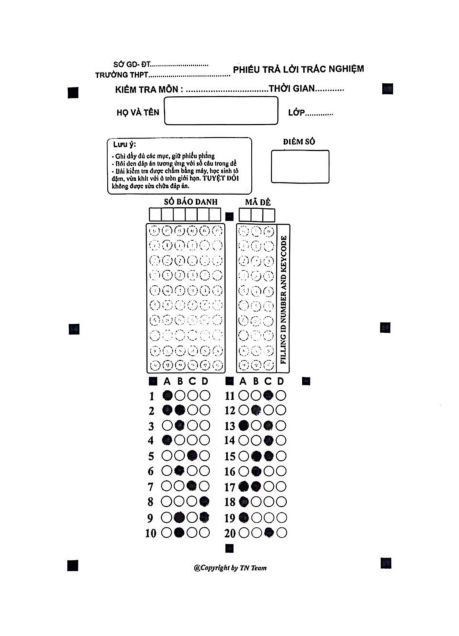

In [3]:
image_path = "./samples/images/img3.jpg"
image = cv2.imread(image_path)
paper = image.copy()

plt.figure(figsize=(6, 8))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

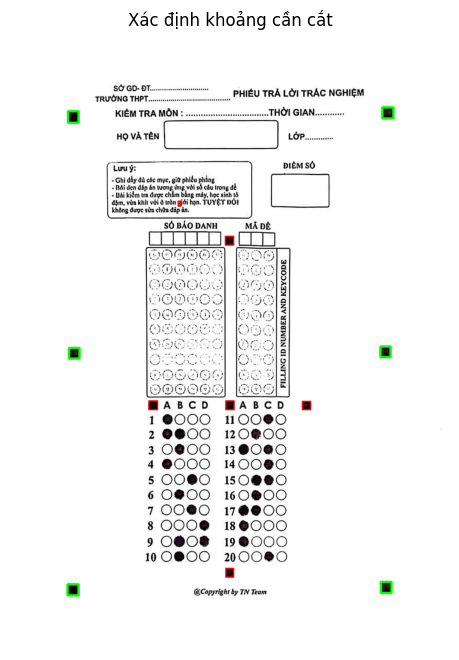

In [4]:
def detect_squares(image):
    
    # Chuyển ảnh sang thang xám
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    _, binary = cv2.threshold(gray, 100, 255, cv2.THRESH_BINARY_INV)

    # Bước 1: Tìm contour
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Bước 2: Phân loại ô vuông đen to / nhỏ
    big_squares = []
    small_squares = []

    for cnt in contours:
        approx = cv2.approxPolyDP(cnt, 0.04 * cv2.arcLength(cnt, True), True)
        if len(approx) == 4:
            x, y, w, h = cv2.boundingRect(cnt)
            area = cv2.contourArea(cnt)
            if abs(w - h) < 5 and area > 30:
                mean_val = np.mean(gray[y:y+h, x:x+w])
                if mean_val < 80:  # là ô đen
                    if w > 20:
                        big_squares.append((x, y, w, h))
                    else:
                        small_squares.append((x, y, w, h))
    
    return big_squares, small_squares

# Gọi hàm phát hiện ô vuông
big_squares, small_squares = detect_squares(image)

# Hiển thị ảnh gốc với các ô vuông được phát hiện
img_drawn = image.copy()
for (x, y, w, h) in big_squares:
    cv2.rectangle(img_drawn, (x, y), (x+w, y+h), (0, 255, 0), 3) 
for (x, y, w, h) in small_squares:
    cv2.rectangle(img_drawn, (x, y), (x+w, y+h), (255, 0, 0), 2) 

plt.figure(figsize=(6, 8))
plt.imshow(img_drawn)
plt.axis("off")
plt.title("Xác định khoảng cần cắt")
plt.show()

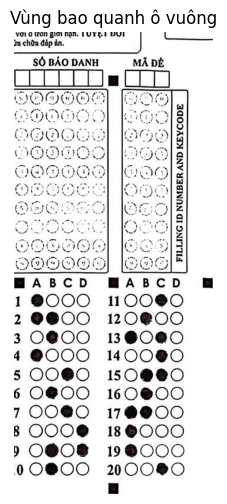

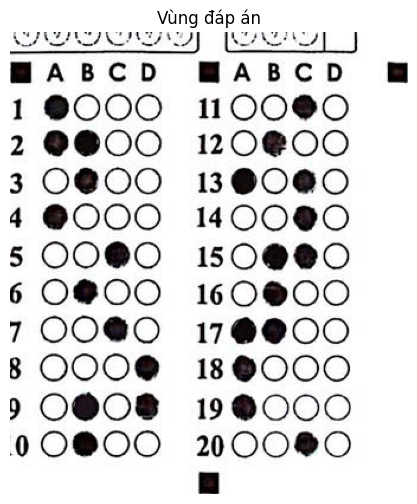

In [5]:
def crop_and_display_answer_block(image, small_squares):
    
    # Cắt vùng bao quanh ô vuông nhỏ
    x_min = min([x for (x, y, w, h) in small_squares])
    x_max = max([x + w for (x, y, w, h) in small_squares])
    y_min = min([y for (x, y, w, h) in small_squares])
    y_max = max([y + h for (x, y, w, h) in small_squares])
    roi = image[y_min:y_max, x_min:x_max]

    # Cắt nửa dưới (vùng đáp án A-B-C-D)
    h_roi, w_roi = roi.shape[:2]
    answer_block = roi[h_roi//2:, :]
    
    return roi, answer_block

roi, cropped_img = crop_and_display_answer_block(image, small_squares)

plt.figure(figsize=(8, 6))
plt.imshow(roi)
plt.axis("off")
plt.title("Vùng bao quanh ô vuông")
plt.show()

# Hiển thị vùng đáp án (nửa dưới)
plt.figure(figsize=(8, 6))
plt.imshow(cropped_img)
plt.axis("off")
plt.title("Vùng đáp án")
plt.show()

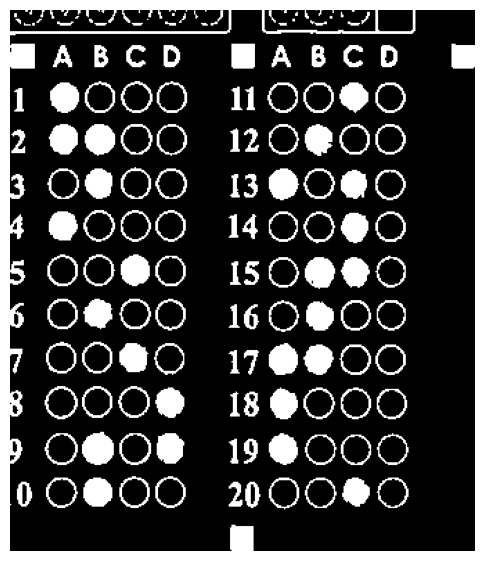

In [6]:

def preprocessingImg(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    return thresh

binary_img = preprocessingImg(cropped_img)

plt.figure(figsize=(6, 8))
plt.imshow(cv2.cvtColor(binary_img, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

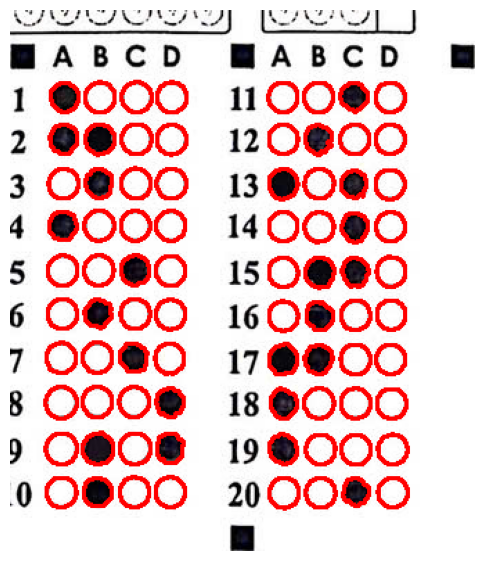

Số ô đáp án phát hiện: 80


In [7]:
def bubble_detection(img):    
    cnts = cv2.findContours(img.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    questionCnts = []

    # Lọc các contour để tìm ô đáp án
    for c in cnts:
        (x, y, w, h) = cv2.boundingRect(c)
        ar = w / float(h)
        area = cv2.contourArea(c)
        if w >= 15 and 20 <= h <= 50 and 0.8 <= ar <= 1.2 and area > 200:
            questionCnts.append(c)

    return questionCnts

questionCnts = bubble_detection(binary_img)
bubble_detections = cropped_img.copy()

cv2.drawContours(bubble_detections, questionCnts, -1, (0, 0, 255), 2)
plt.figure(figsize=(6, 8))

plt.imshow(cv2.cvtColor(bubble_detections, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.show()
print(f"Số ô đáp án phát hiện: {len(questionCnts)}")


Câu 1: 4 ô đáp án
Câu 2: 4 ô đáp án
Câu 3: 4 ô đáp án
Câu 4: 4 ô đáp án
Câu 5: 4 ô đáp án
Câu 6: 4 ô đáp án
Câu 7: 4 ô đáp án
Câu 8: 4 ô đáp án
Câu 9: 4 ô đáp án
Câu 10: 4 ô đáp án
Câu 11: 4 ô đáp án
Câu 12: 4 ô đáp án
Câu 13: 4 ô đáp án
Câu 14: 4 ô đáp án
Câu 15: 4 ô đáp án
Câu 16: 4 ô đáp án
Câu 17: 4 ô đáp án
Câu 18: 4 ô đáp án
Câu 19: 4 ô đáp án
Câu 20: 4 ô đáp án


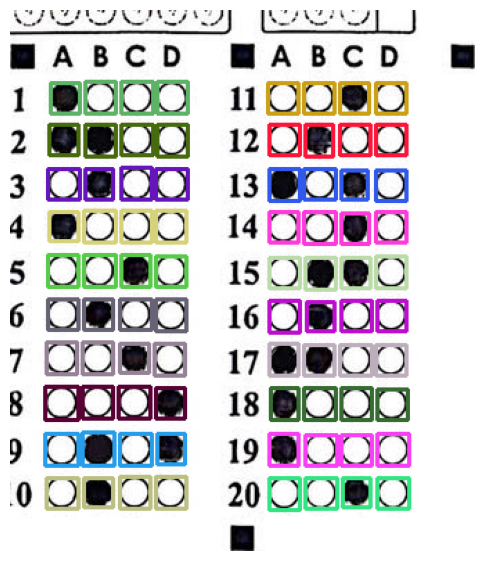

In [ ]:
np.random.seed(42)
colors = [tuple(np.random.randint(0, 255, 3).tolist()) for _ in range(20)]

# Sắp xếp các ô đáp án theo bố cục phiếu trắc nghiệm
def sort_answer_contours(questionCnts, cropped_img):
    # Sắp xếp tất cả contour từ trên xuống dưới
    questionCnts = contours.sort_contours(questionCnts, method="top-to-bottom")[0]

    col1_contours = []
    col2_contours = []

    # Tìm x trung bình để chia cột
    x_coords = [cv2.boundingRect(c)[0] for c in questionCnts]
    x_median = np.median(x_coords)
    for c in questionCnts:
        (x, y, w, h) = cv2.boundingRect(c)
        if x < x_median:
            col1_contours.append(c)
        else:
            col2_contours.append(c)

    # Sắp xếp contour trong mỗi cột từ trên xuống dưới
    col1_contours = contours.sort_contours(col1_contours, method="top-to-bottom")[0]``
    col2_contours = contours.sort_contours(col2_contours, method="top-to-bottom")[0]

    questions = []
    for col_contours in [col1_contours, col2_contours]:
        current_row = []
        prev_y = None
        for c in col_contours:
            (x, y, w, h) = cv2.boundingRect(c)
            if prev_y is None or abs(y - prev_y) > h * 1.0:  # Ngưỡng y để phân biệt hàng
                if current_row:
                    current_row = contours.sort_contours(current_row, method="left-to-right")[0]
                    questions.append(current_row)
                current_row = [c]
            else:
                current_row.append(c)
            prev_y = y
        if current_row:
            current_row = contours.sort_contours(current_row, method="left-to-right")[0]
            questions.append(current_row)

    return questions

questions = sort_answer_contours(questionCnts, cropped_img)



visual_img = cropped_img.copy()
for q, row in enumerate(questions):
    print(f"Câu {q + 1}: {len(row)} ô đáp án")

    color = colors[q]
    for c in row:
        (x, y, w, h) = cv2.boundingRect(c)
        cv2.rectangle(visual_img, (x, y), (x + w, y + h), color, 2)

plt.figure(figsize=(6, 8))
plt.imshow(cv2.cvtColor(visual_img, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

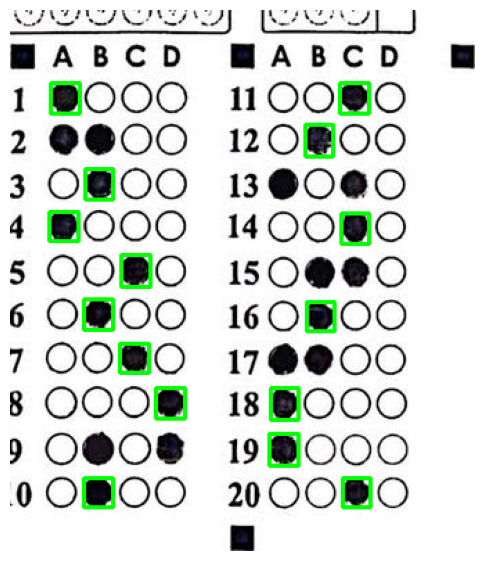

Số câu trả lời đúng: 15/20

Điểm: 7.5

Đáp án đúng:
1 : A
2 : A
3 : B
4 : A
5 : C
6 : B
7 : C
8 : D
9 : D
10 : B
11 : C
12 : B
13 : C
14 : C
15 : C
16 : B
17 : B
18 : A
19 : A
20 : C


In [9]:
def grade_answer_sheet(questions, thresh, cropped_img, answer_key):
    correct = 0
    visual_img = cropped_img.copy()
    answer_map = {0: 'A', 1: 'B', 2: 'C', 3: 'D'}
    correct_answer = []
    detected_answers = {}
    min_filled_threshold = 200
    multiple_choice_errors = 0

    for q, row in enumerate(questions):
        bubbled = []
        filled_values = []

        for j, c in enumerate(row):
            mask = np.zeros(thresh.shape, dtype="uint8")
            cv2.drawContours(mask, [c], -1, 255, -1)
            mask = cv2.bitwise_and(thresh, thresh, mask=mask)
            total = cv2.countNonZero(mask)
            if total >= min_filled_threshold:
                bubbled.append(j)
                filled_values.append(total)

        if len(bubbled) == 1:
            detected_answers[q] = bubbled[0]
            if q < len(ANSWER_KEY):
                correct_answer.append(answer_map[ANSWER_KEY[q]])
                (x, y, w, h) = cv2.boundingRect(row[bubbled[0]])
                if bubbled[0] == ANSWER_KEY[q]:
                    correct += 1
                    cv2.rectangle(visual_img, (x, y), (x + w, y + h), (0, 255, 0), 2)
                else:
                    cv2.rectangle(visual_img, (x, y), (x + w, y + h), (0, 0, 255), 2)
        else:
            detected_answers[q] = None
            if len(bubbled) > 1:
                multiple_choice_errors += 1
            if q < len(ANSWER_KEY):
                correct_answer.append(answer_map[ANSWER_KEY[q]])

    score = 10 * correct / len(ANSWER_KEY) if len(ANSWER_KEY) > 0 else 0.0

    return correct, score, visual_img, correct_answer, detected_answers

correct, score, visual_img, correct_answer, detected_answers = grade_answer_sheet(questions, binary_img, cropped_img, ANSWER_KEY)

plt.figure(figsize=(6, 8))
plt.imshow(cv2.cvtColor(visual_img, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

print(f"Số câu trả lời đúng: {correct}/{len(ANSWER_KEY)}\n")
print(f"Điểm: {score}\n")

print(f"Đáp án đúng:")
for q in range(len(correct_answer)):
    print(f"{q + 1} : {correct_answer[q]}")